In [1]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.convtools import conviter
# from deepmeg.models.interpretable import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.interpreters import SPIRITInterpreter
import random


In [2]:
def generate_activations(
    event_names, roi_labels, n_rois=1
):
    start = 0
    random.shuffle(roi_labels)
    activations = dict()

    for event in event_names:
        n_rois_sel = int(np.random.randint(1, n_rois+1))
        sel_rois = roi_labels[start:start+n_rois_sel]
        activations[event] = [(sel_roi.name, int(np.random.randint(10, 100))) for sel_roi in sel_rois]
        start += n_rois_sel

        if start >= len(roi_labels):
            break

    return activations


def plot_roi(roi_labels, subject, subjects_dir, colors=None, marker_sizes=None):
    coords = list()
    for roi_label in roi_labels:
        if roi_label.name[-2:] == 'lh':
            hemi = 0
        elif roi_label.name[-2:] == 'rh':
            hemi = 1
        else: raise ValueError(f'Hemisphere undefined: {roi_label.name}')

        coords.append(
            mne.vertex_to_mni(
                roi_label.center_of_mass(
                    subject,
                    subjects_dir=subjects_dir
                ),
                hemi,
                subject,
                subjects_dir=subjects_dir
            )
        )
    if isinstance(colors, str):
        colors = [colors for _ in coords]
    view = plotting.view_markers(
        coords, colors,
        marker_size=marker_sizes
    )
    return view


def data_fun(times, latency, duration, rng=None, f = 15):
    """Function to generate source time courses for evoked responses,
    parametrized by latency and duration."""
    if not rng:
        rng = np.random.RandomState(7)
    sigma = 0.375 * duration
    sinusoid = np.sin(2 * np.pi * f * (times - latency))
    gf = np.exp(- (times - latency - (sigma / 4.) * rng.rand(1)) ** 2 /
                (2 * (sigma ** 2)))
    return 1e-9 * sinusoid * gf


# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [3]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

from deepmeg.models import BaseModel

class Fourier(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))

        self.a0 = nn.Parameter(torch.empty(1))


        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        out = self.a0/(2*self.n_points)*torch.ones_like(x)
        for n in range(self.n_components):
            out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

        return out


class FourierNet(BaseModel):

    def __init__(self, n_points, n_components=None):
        super().__init__()

        if n_components is None:
            n_components = n_points//2

        self.layer = Fourier(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x

from deepmeg.convtools import compute_output_shape, conviter

class AutoCov1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        # self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))
        self.transform = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])
        self.transform2 = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # init.uniform_(self.weight, -0.01, 0.01)
        if self.bias is not None:
            init.uniform_(self.bias, -0.01, 0.01)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, len(self.transform)) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(len(self.transform)):
            for p, q, k in conviter(*convargs):
                # p shape: n_times, ...
                # q shape: n_windows, 0
                # k shape: window_size, ...
                pad_params = list()

                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                if window_range.start is not None and abs(window_range.start) < self.window_size:
                    pad_params.append(abs(window_range.start))
                else:
                    pad_params.append(0)
                if window_range.stop is not None and abs(window_range.stop) < self.window_size:
                    pad_params.append(abs(window_range.stop))
                else:
                    pad_params.append(0)

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]

                if pad_params != [0, 0]:
                    window1 = nn.functional.pad(window1, pad_params)
                    window2 = nn.functional.pad(window2, pad_params)

                # weight = self.weight[window_range, :, n_neuron]

                # proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                # proj2 = torch.matmul(window2, weight)
                proj1 = self.transform[n_neuron](window1)
                proj2 = self.transform2[n_neuron](window2)

                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)

        return out_tensor

# X = torch.rand(100, 204)
# AutoCov1D(1, 20, 20, 0, 20, 10)(X)


class SPIRIT(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                AutoCov1D(1, window_size, latent_dim, 0, window_size, bias=True),
            )
            for _ in range(n_latent)
        ])
        self.expander = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=(2,),
            padding=1
        )
        self.windows = [win for win, _, _ in conviter((n_times-(window_size),), window_size, 0, window_size)]
        self.windows.append(slice(self.windows[-1].start + window_size, None))
        self.timecomp_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    n_times,
                    (n_times//pool_factor),
                    bias=False
                ),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for i in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )

        x_est = torch.squeeze(x_est, -1)
        x_est = self.expander(x_est)

        x_out = list()
        for i, window in enumerate(self.windows):
            x_out.append(
                x[:, :, window]
                *torch.unsqueeze(x_est[:, :, i], -1)
            )

        x = torch.cat(x_out, -1)

        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timecomp_list)
            ],
            1
        )
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


# SPIRIT(
#     **model_kwargs
# )(X)

In [4]:
from collections import namedtuple

EventConfig = namedtuple('EventConfig', 'start duration id')


def create_events(*configs: EventConfig, duration, sfreq):
    n_points = int(duration*sfreq)
    all_events = list()
    for config in configs:
        currect_timepoint = int(config.start*sfreq)
        events = list()
        while currect_timepoint < n_points:
            events.append([currect_timepoint, 0, config.id])
            currect_timepoint += int(config.duration*sfreq)
        all_events += events
    all_events = np.array(all_events)
    return all_events[np.argsort(all_events[:, 0])]


In [5]:
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_info = meg_path / 'sample_audvis_raw.fif'
info_orig = mne.io.read_info(fname_info)
tstep = 1 / info_orig['sfreq']
fwd_fname = meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
fname_cov = meg_path / 'sample_audvis-cov.fif'

events = mne.read_events(fname_event)

# events = create_events(
#     EventConfig(10.6, 1.25, 1),
#     EventConfig(11.2, 1.5, 2),
#     EventConfig(12.0, 1., 3),
#     EventConfig(11.8, 1., 4),
#     EventConfig(11.2, 1.25, 4),
#     EventConfig(10.4, 1.5, 4),
#     duration=200,
#     sfreq=info_orig['sfreq']
# )

noise_cov = mne.read_cov(fname_cov)

event_id = {'e1': 1, 'e2': 2, 'e3': 3,
            'e4': 4, 'e5': 5, 'e6': 32}

all_labels = mne.read_labels_from_annot('sample', parc='aparc.a2009s', subjects_dir=subjects_dir)
label_by_name = {label.name: label for label in all_labels}


In [6]:
label_by_name.keys()

dict_keys(['G_Ins_lg_and_S_cent_ins-lh', 'G_Ins_lg_and_S_cent_ins-rh', 'G_and_S_cingul-Ant-lh', 'G_and_S_cingul-Ant-rh', 'G_and_S_cingul-Mid-Ant-lh', 'G_and_S_cingul-Mid-Ant-rh', 'G_and_S_cingul-Mid-Post-lh', 'G_and_S_cingul-Mid-Post-rh', 'G_and_S_frontomargin-lh', 'G_and_S_frontomargin-rh', 'G_and_S_occipital_inf-lh', 'G_and_S_occipital_inf-rh', 'G_and_S_paracentral-lh', 'G_and_S_paracentral-rh', 'G_and_S_subcentral-lh', 'G_and_S_subcentral-rh', 'G_and_S_transv_frontopol-lh', 'G_and_S_transv_frontopol-rh', 'G_cingul-Post-dorsal-lh', 'G_cingul-Post-dorsal-rh', 'G_cingul-Post-ventral-lh', 'G_cingul-Post-ventral-rh', 'G_cuneus-lh', 'G_cuneus-rh', 'G_front_inf-Opercular-lh', 'G_front_inf-Opercular-rh', 'G_front_inf-Orbital-lh', 'G_front_inf-Orbital-rh', 'G_front_inf-Triangul-lh', 'G_front_inf-Triangul-rh', 'G_front_middle-lh', 'G_front_middle-rh', 'G_front_sup-lh', 'G_front_sup-rh', 'G_insular_short-lh', 'G_insular_short-rh', 'G_oc-temp_lat-fusifor-lh', 'G_oc-temp_lat-fusifor-rh', 'G_oc-t

In [9]:
activations = {
    'e1': [
        ('S_interm_prim-Jensen-rh', 11),
        ('S_intrapariet_and_P_trans-rh', 7)
        # ('S_oc_middle_and_Lunatus-rh', 53),
    ],
    'e2': [
        ('S_oc-temp_lat-rh', 17),
        ('S_oc-temp_med_and_Lingual-rh', 9),
    ],
    'e3': [
        ('S_circular_insula_inf-rh', 18),
        ('S_collat_transv_post-rh', 8)
        # ('G_orbital-rh', 70)
    ],
}

In [8]:
new_activations = generate_activations(
    [
        'e4',
        'e5', 'e6'
    ], all_labels, 8
)

In [10]:
# all_activations = dict(**activations, **new_activations)
all_activations = activations

In [11]:

labels = list()
marker_sizes = list()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
all_colors = list()
for color, (event_name, activation) in zip(colors, all_activations.items()):
    for a in activation:
        labels.append(label_by_name[a[0]])
        marker_sizes.append(a[1])
        all_colors.append(color)

plot_roi(labels, 'sample', subjects_dir, all_colors, marker_sizes)

In [12]:
annot = 'aparc.a2009s'
label_names = sorted(set(activation[0]
                         for activation_list in all_activations.values()
                         for activation in activation_list))
region_names = list(all_activations.keys())

In [13]:
times = np.arange(600, dtype=np.float64) / info_orig['sfreq']
rng = np.random.RandomState(7)
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

# durations = [0.05, 0.08, 0.1]
# latencies = [0.1, 0.5, 0.8]
# freqs = [10., 20., 30.]

cfg_data = dict()

for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(len(all_activations[region_name])):
        label_name = all_activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(subject, annot,
                                               subjects_dir=subjects_dir,
                                               regexp=label_name,
                                               verbose=False)
        label_tmp = label_tmp[0]
        amplitude_tmp = all_activations[region_name][i][1]

        if region_name in activations.keys():
            duration = np.random.uniform(0.01, 0.1)
            # duration = durations[region_id-1]
            latency_tmp = np.random.uniform(0.1, 0.6)
            # latency_tmp = latencies[region_id-1]
            f = np.random.uniform(8., 30.)
        else:
            duration = np.random.uniform(0.01, 0.5)
            latency_tmp = np.random.uniform(0.1, 1.6)
            f = np.random.uniform(8., 30.)
        if region_name not in cfg_data:
            cfg_data[region_name] = dict()
        cfg_data[region_name][label_name] = dict(duration=duration, latency=latency_tmp, frequency=f)
        # f = freqs[region_id-1]
        wf_tmp = data_fun(times, latency_tmp, duration, f=f)
        source_simulator.add_data(label_tmp,
                                  amplitude_tmp * wf_tmp,
                                  events_tmp)

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()

In [14]:
for event, eventdict in cfg_data.items():
    print(f'{event}:')
    for region, regiondict in eventdict.items():
        print(f'\t{region}:')
        for param, value in regiondict.items():
            print(f'\t\t{param}: {value}')

e1:
	S_interm_prim-Jensen-rh:
		duration: 0.04725547411824546
		latency: 0.2743612127221593
		frequency: 16.605145087546898
	S_intrapariet_and_P_trans-rh:
		duration: 0.023633726746583886
		latency: 0.4275004687692071
		frequency: 13.874855648099345
e2:
	S_oc-temp_lat-rh:
		duration: 0.022558531403378018
		latency: 0.32332068919410906
		frequency: 22.6902126197408
	S_oc-temp_med_and_Lingual-rh:
		duration: 0.06709258167277772
		latency: 0.5157857917943334
		frequency: 9.367252903712474
e3:
	S_circular_insula_inf-rh:
		duration: 0.09063716175773327
		latency: 0.3607482214818193
		frequency: 29.641760724443323
	S_collat_transv_post-rh:
		duration: 0.08334145309502285
		latency: 0.12315458513269897
		frequency: 9.12238267391098


In [15]:
raw_sim = mne.simulation.simulate_raw(info_orig, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(projection=True)

mne.simulation.add_noise(
    raw_sim,
    cov=noise_cov,
    random_state=0
)

<RawArray | 376 x 154680 (257.5 s), ~447.0 MB, data loaded>

In [16]:
epochs = mne.Epochs(raw_sim, events, event_id, tmin=-0.2, tmax=2.,
                    baseline=(None, 0), event_repeated='drop')
epochs.load_data().resample(600).crop(0., None).pick_types(meg='grad')
epochsoi = epochs[['e1', 'e2', 'e3']]
evo = epochsoi.average(by_event_type=True)

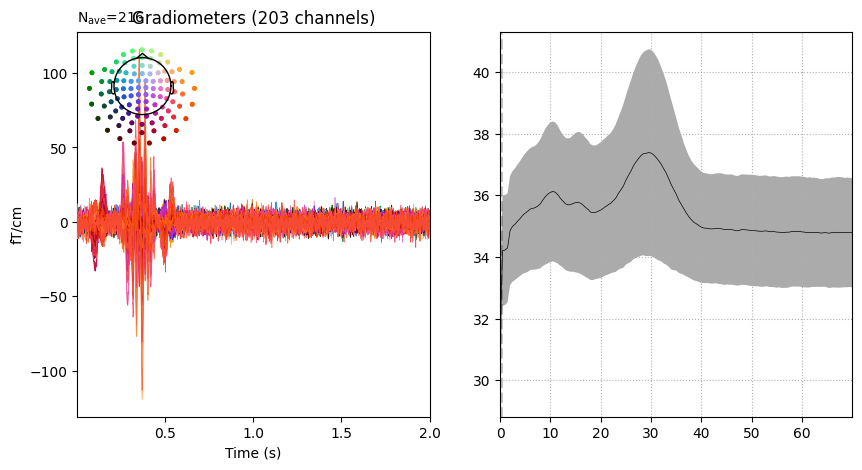

In [18]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
epochsoi.plot_psd(average=True, ax=ax2, fmax=70)
epochsoi.average().plot(axes=ax1)
plt.show()

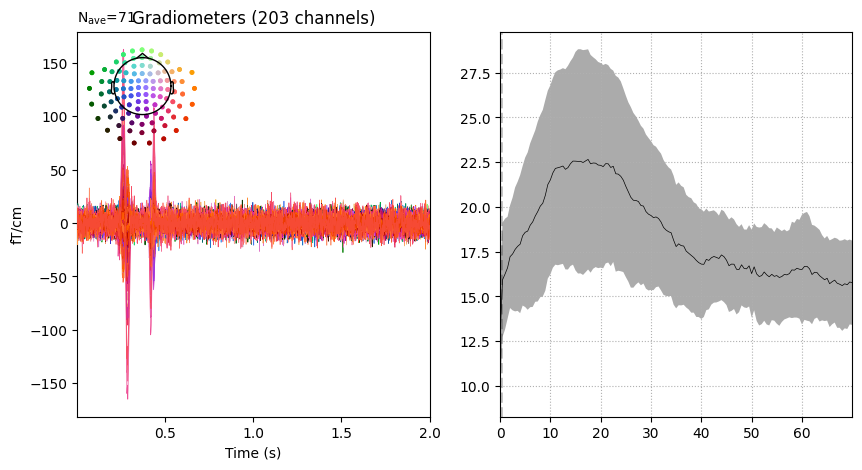

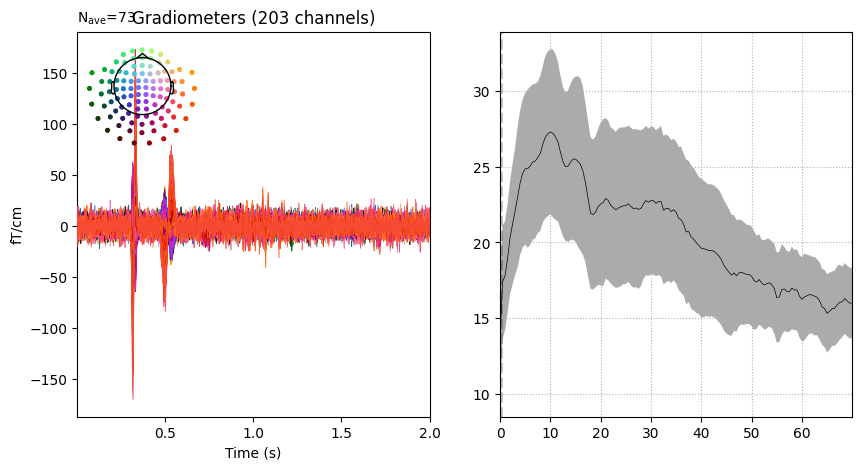

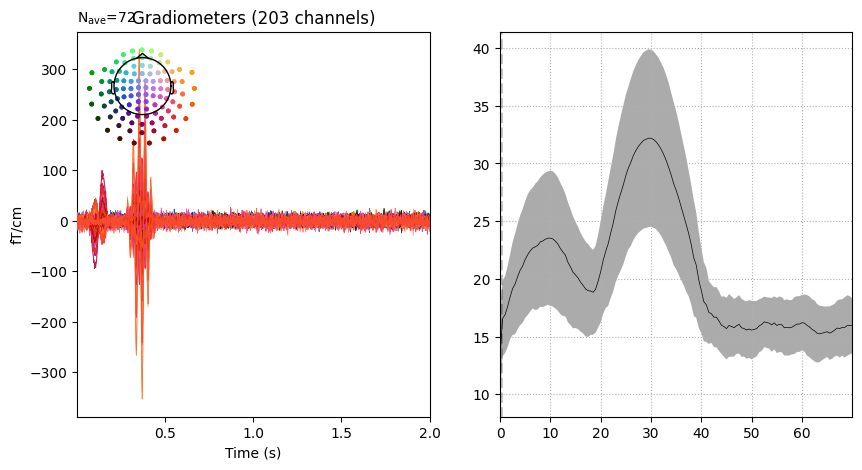

In [19]:
for evoked in evo:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    evoked.plot_psd(average=True, ax=ax2, fmax=70)
    evoked.plot(axes=ax1)
    plt.show()

In [46]:
data = epochsoi.get_data().copy()
labels = epochsoi.events[:, 2]

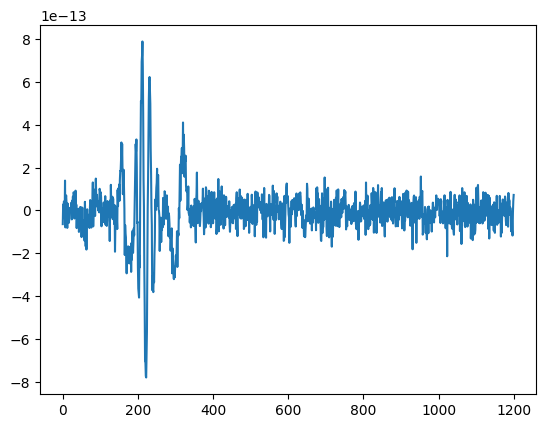

In [21]:
plt.plot(data.mean((0,1)))
plt.show()

In [33]:
data.shape

(216, 203, 1201)

In [45]:
data[:, :, 400:] = 2*5e-10*np.random.random((216, 203, 801)) - 5e-10

In [47]:
data += 2*6e-11*np.random.random((216, 203, 1201)) - 6e-11

In [58]:
data += 2*1e-10*np.random.random((216, 203, 1201)) - 1e-10

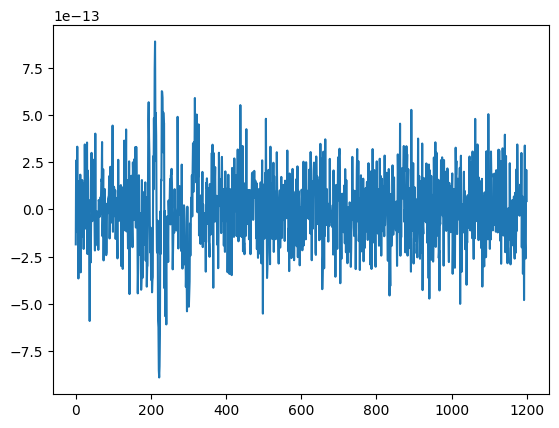

In [48]:
plt.plot(data.mean((0,1)))
plt.show()

In [49]:
from deepmeg.preprocessing.transforms import one_hot_encoder
dataset = EpochsDataset(
    (
        # epochsoi
        data,
        one_hot_encoder(labels)
    ),
    savepath='../simulated_noisy',
    transform=zscore
)

In [27]:
dataset.save('../dataset/simulated_noisy.pt')

In [4]:
dataset = read_epochs_dataset('../dataset/simulated_noisy.pt')

In [50]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [26]:
kwargs = dict(
    n_channels=203,
    n_latent=8,
    # n_times=601,
    n_times=1201,
    filter_size=50,
    window_size=10,
    latent_dim=10,
    pool_factor=10,
    n_outputs=3
)

In [51]:
from deepmeg.models.interpretable import LFCNN

model = LFCNN(
    n_channels=203, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=1201,
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=3 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7277   |    binary_accuracy_train:  0.5128   |    loss_val:  0.7269   |    binary_accuracy_val:  0.5333
Epoch 1:  loss_train:  0.7079   |    binary_accuracy_train:  0.5840   |    loss_val:  0.7225   |    binary_accuracy_val:  0.5810
Epoch 2:  loss_train:  0.6886   |    binary_accuracy_train:  0.6752   |    loss_val:  0.7183   |    binary_accuracy_val:  0.6000
Epoch 3:  loss_train:  0.6698   |    binary_accuracy_train:  0.7436   |    loss_val:  0.7141   |    binary_accuracy_val:  0.6286
Epoch 4:  loss_train:  0.6514   |    binary_accuracy_train:  0.7806   |    loss_val:  0.7100   |    binary_accuracy_val:  0.6381
Epoch 5:  loss_train:  0.6332   |    binary_accuracy_train:  0.8205   |    loss_val:  0.7061   |    binary_accuracy_val:  0.6476
Epoch 6:  loss_train:  0.6152   |    binary_accuracy_train:  0.8661   |    loss_val:  0.7022   |    binary_accuracy_val:  0.6381
Epoch 7:  loss_train:  0.5973   |    binary_accuracy_train:  0.8860   |    loss_val:  0.6985   | 

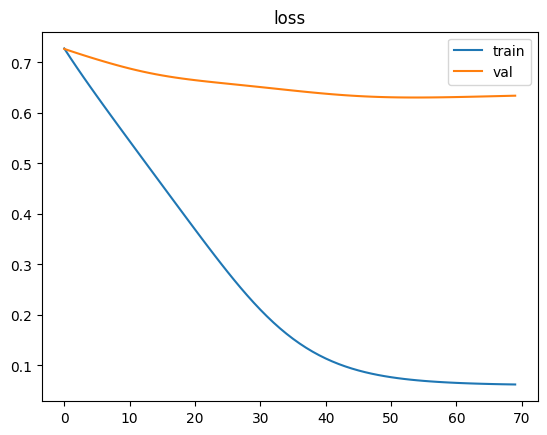

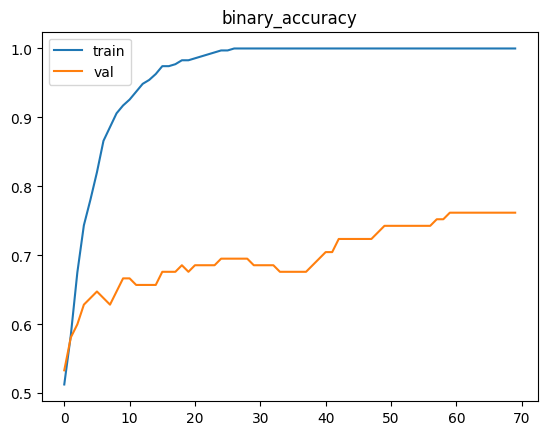

In [52]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [58]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.6518381346355785
train_binary_accuracy: 0.6666666865348816
loss: 0.6842703548344699
binary_accuracy: 0.6666666865348816


In [ ]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [56]:
model = SPIRIT(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                # *[f'timesel_list.{i}.0.transform.0.layer.a0' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform.0.layer.a' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform.0.layer.b' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform2.0.layer.a0' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform2.0.layer.a' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform2.0.layer.b' for i in range(8)],
                # *[f'timecomp_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01,
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)]
            ]
            # lambdas=.01
        )  # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7122   |    binary_accuracy_train:  0.5499   |    loss_val:  0.6856   |    binary_accuracy_val:  0.6667
Epoch 1:  loss_train:  0.6730   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6788   |    binary_accuracy_val:  0.6667
Epoch 2:  loss_train:  0.6682   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6769   |    binary_accuracy_val:  0.6667
Epoch 3:  loss_train:  0.6702   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6738   |    binary_accuracy_val:  0.6667
Epoch 4:  loss_train:  0.6689   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6695   |    binary_accuracy_val:  0.6667
Epoch 5:  loss_train:  0.6627   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6655   |    binary_accuracy_val:  0.6667
Epoch 6:  loss_train:  0.6536   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6652   |    binary_accuracy_val:  0.6667
Epoch 7:  loss_train:  0.6449   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6689   | 

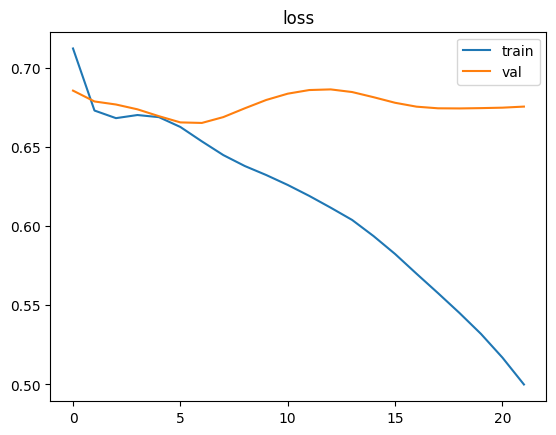

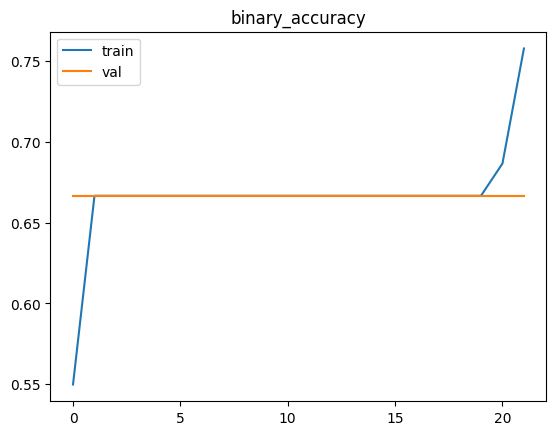

In [57]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [97]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.13203397325494073
train_binary_accuracy: 0.9717171734029596
loss: 0.9949129548939791
binary_accuracy: 0.6666666756976735


In [ ]:
interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [41]:
from deepmeg.models.interpretable import SPIRIT as SPIRIT_old

model = SPIRIT_old(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                # *[f'timesel_list.{i}.0.transform.0.layer.a' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform.0.layer.b' for i in range(8)],
                # *[f'timecomp_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01,
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)],
                # *[.001 for _ in range(8)]
            ]
            # lambdas=.01
        )  # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7835   |    binary_accuracy_train:  0.4615   |    loss_val:  0.6905   |    binary_accuracy_val:  0.6000
Epoch 1:  loss_train:  0.7022   |    binary_accuracy_train:  0.5442   |    loss_val:  0.6707   |    binary_accuracy_val:  0.6667
Epoch 2:  loss_train:  0.6747   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6789   |    binary_accuracy_val:  0.6667
Epoch 3:  loss_train:  0.6681   |    binary_accuracy_train:  0.6667   |    loss_val:  0.6937   |    binary_accuracy_val:  0.6667
Epoch 4:  loss_train:  0.6650   |    binary_accuracy_train:  0.6667   |    loss_val:  0.7085   |    binary_accuracy_val:  0.6667
Epoch 5:  loss_train:  0.6619   |    binary_accuracy_train:  0.6667   |    loss_val:  0.7215   |    binary_accuracy_val:  0.6667
Epoch 6:  loss_train:  0.6587   |    binary_accuracy_train:  0.6667   |    loss_val:  0.7312   |    binary_accuracy_val:  0.6667
Epoch 7:  loss_train:  0.6554   |    binary_accuracy_train:  0.6667   |    loss_val:  0.7345   | 

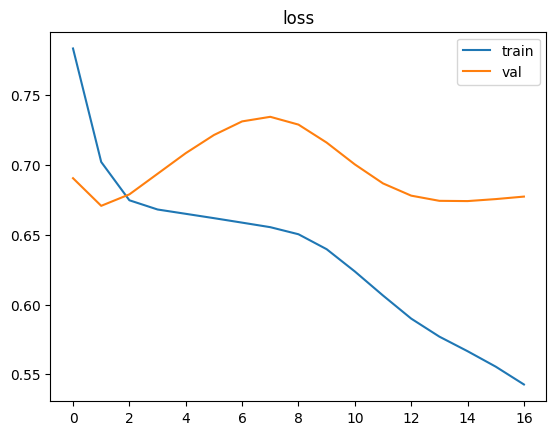

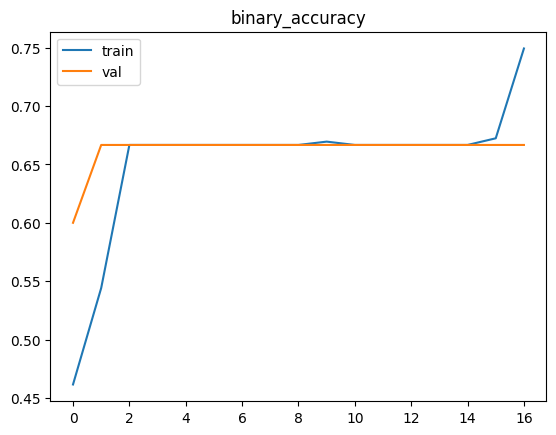

In [42]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [80]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.21822522580623627
train_binary_accuracy: 0.9353535392067649
loss: 0.7191860025579279
binary_accuracy: 0.6666666865348816


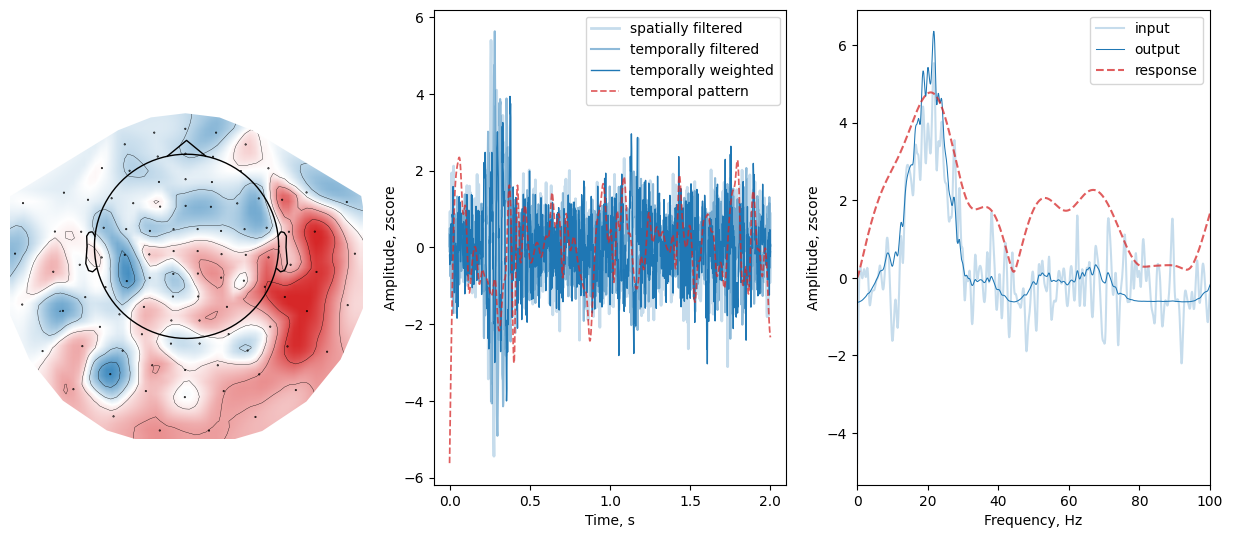

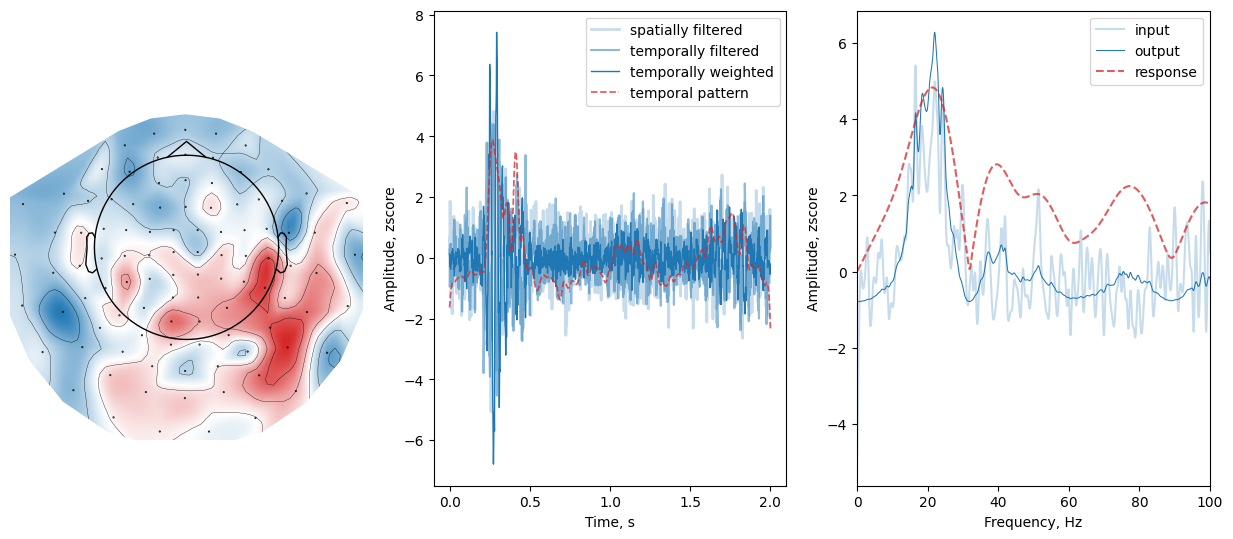

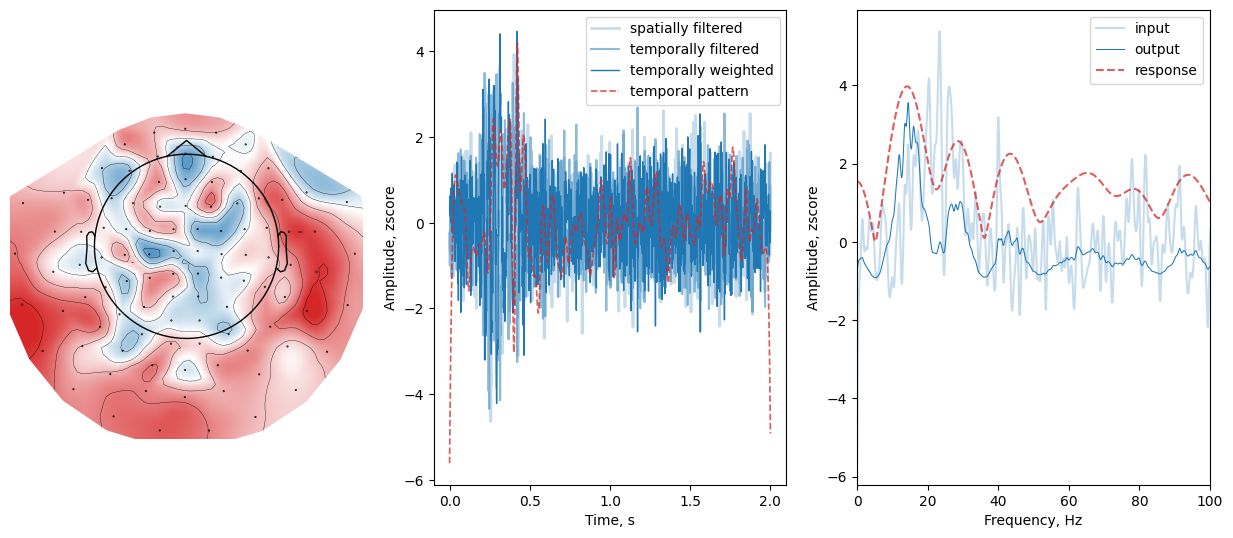

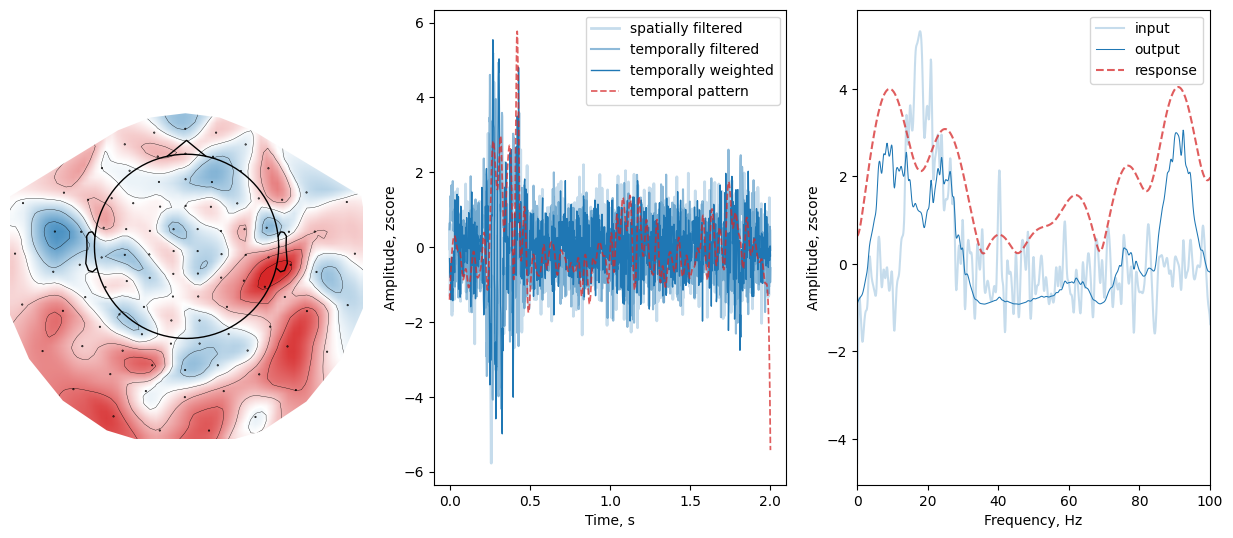

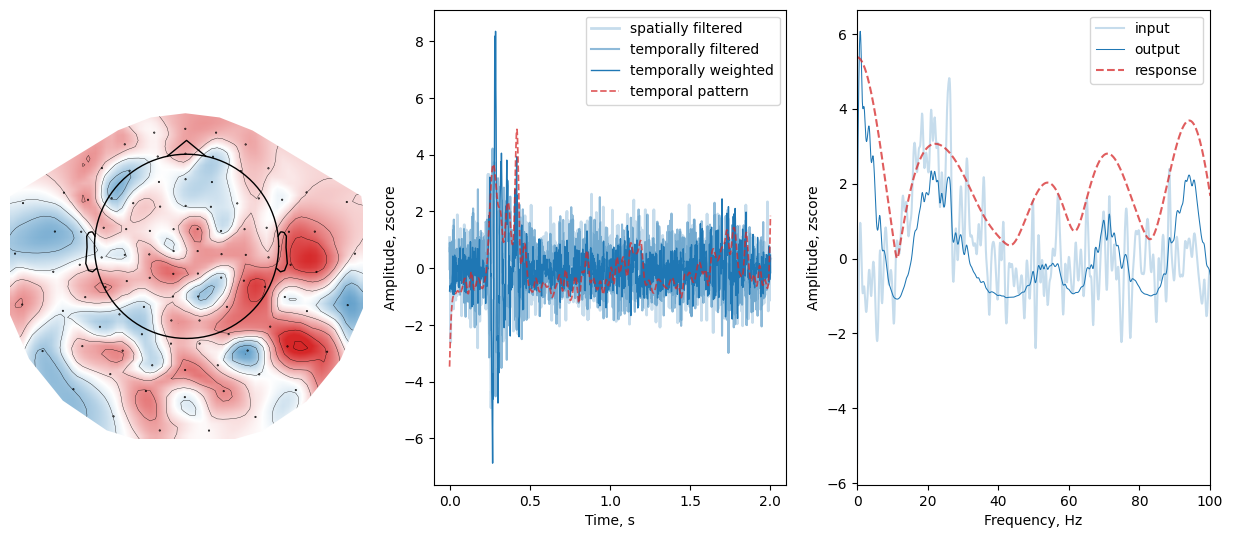

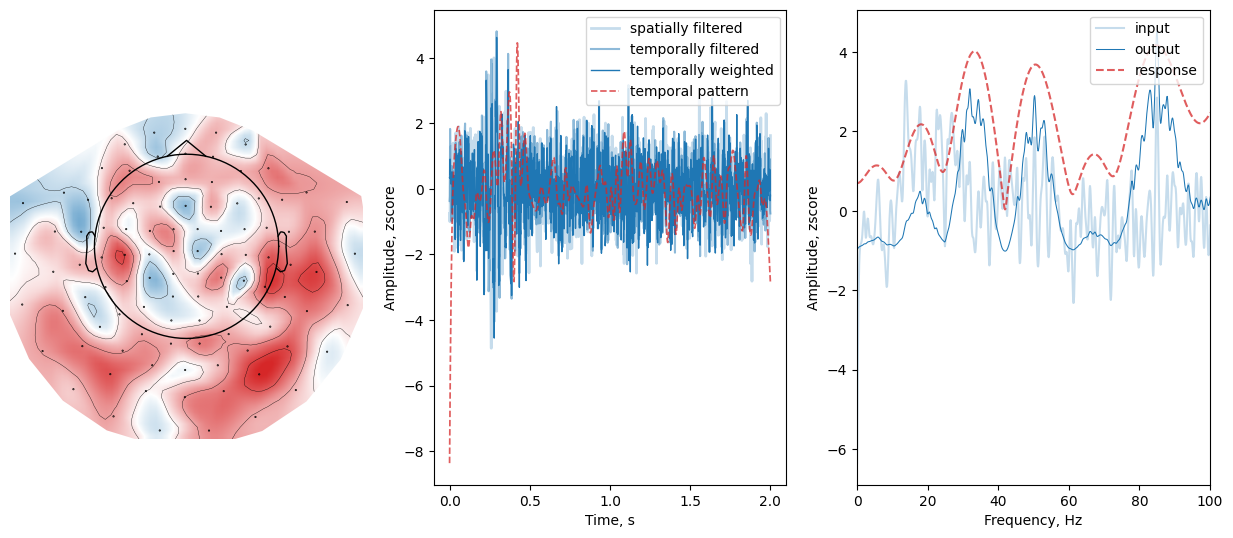

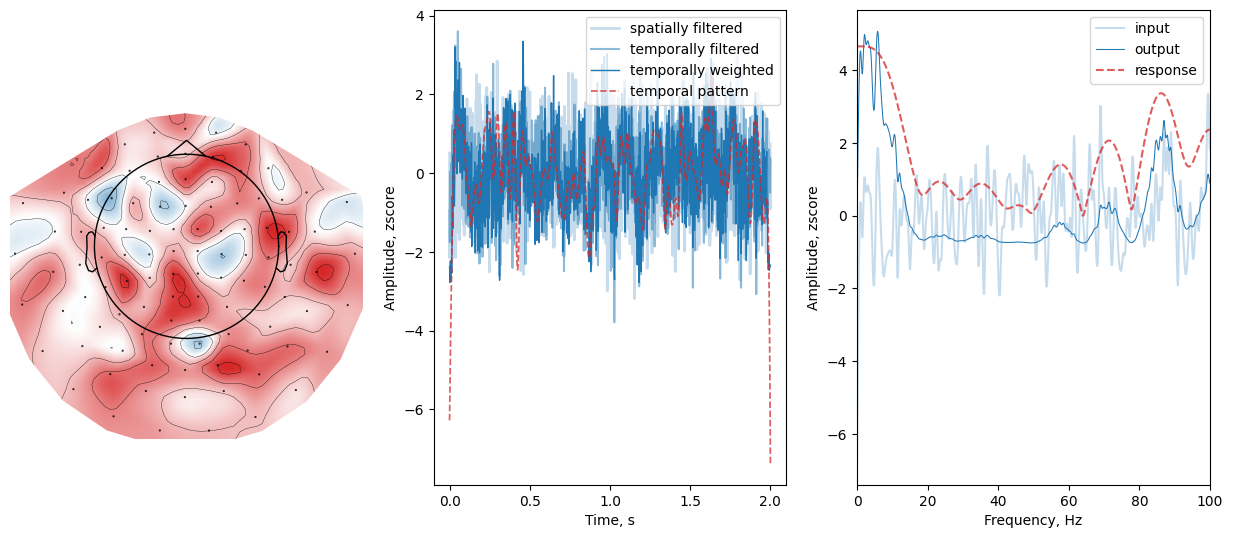

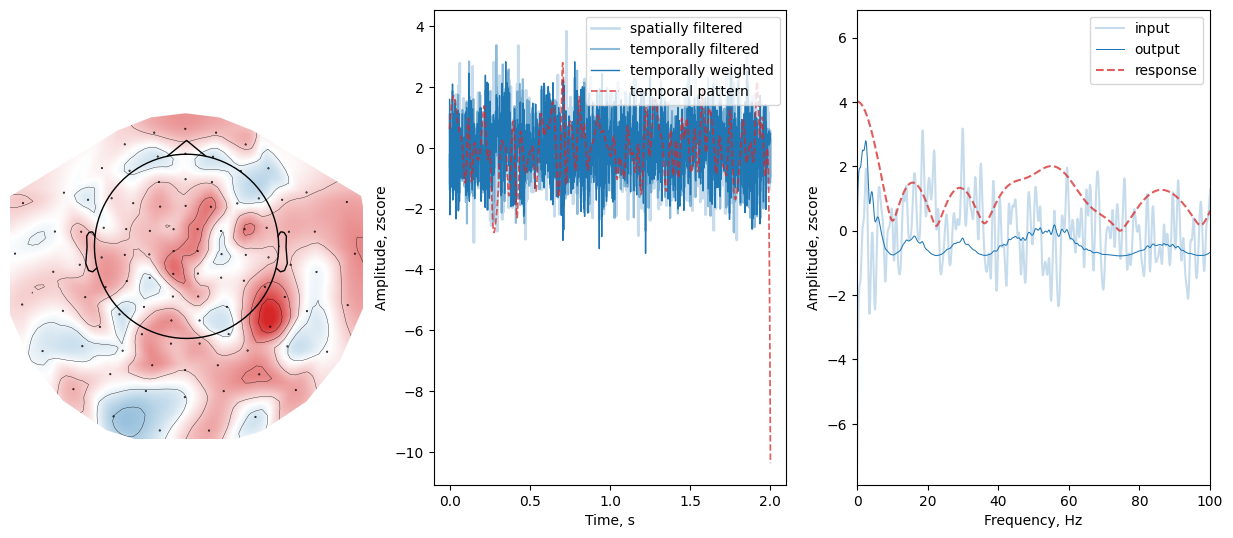

In [52]:
interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()